In [1]:
%cd '..'

/home/dsi/toozig/Deep-learning-RNA-binding


/home/dsi/toozig/.virtualenvs/deepBindEnv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils.HTS_data_processing import process_HTS_raw_files


In [32]:
# the 8-mers enrichment data generating code can be found in the prepare_enrichment_json.py
enrichment_path = 'comapre_enrichment/8mers_enrichment.json'
enrichment = json.load(open(enrichment_path))
have_rnac = os.listdir('data/raw_data/RNAcompete_intensities')
have_rnac = [x.split('.')[0] for x in have_rnac]
enrichment_df = pd.DataFrame(enrichment)
enrichment_df.head()
enrichment_df.columns = [i.split('_')[0] for i in enrichment_df.columns]
# HTS 8-mers enrichment data
# calculate the similarity between the 8-mers enrichment data
corr_df = enrichment_df.corr()

Text(1.3, 0.5, 'Pearson correlation')

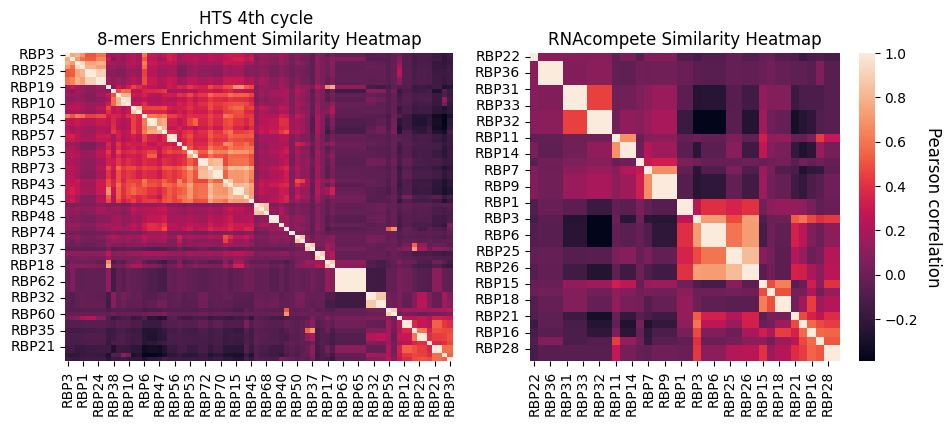

In [16]:
# Create a figure with 1 row and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(11, 4))  # Adjust the size as needed

mers_cols_order = enrichment_df.columns[cg_mers.dendrogram_row.reordered_ind]
sns.heatmap(corr_df[mers_cols_order].loc[mers_cols_order], ax=axs[0], cbar=False)
axs[0].set_title('HTS 4th cycle \n8-mers Enrichment Similarity Heatmap')
# remove the legend



rnac_cols_order = rnac_corr.columns[cg_rnac.dendrogram_row.reordered_ind]
rnac_corr_path = '/home/dsi/toozig/Deep-learning-RNA-binding/correlation_matrix.csv'
rnac_corr = pd.read_csv(rnac_corr_path, index_col=0)
sns.heatmap(rnac_corr[rnac_cols_order].loc[rnac_cols_order], ax=axs[1])
axs[1].set_title('RNAcompete Similarity Heatmap')
# write 'pearson correlation' on the outside of ax[1] n the right sied 90 degree rotated
axs[1].text(1.3, 0.5, 'Pearson correlation', rotation=270, verticalalignment='center', horizontalalignment='center', transform=axs[1].transAxes, fontsize=12)

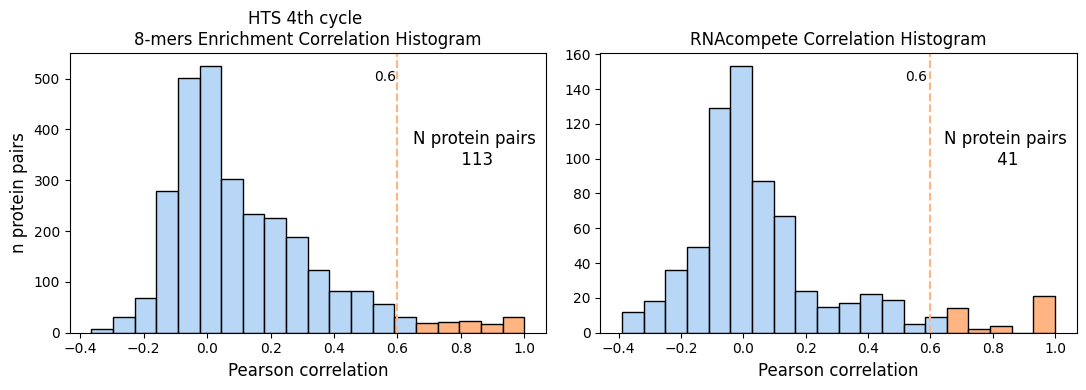

In [57]:
# plot histogram of the correlation values
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

mers_corr = corr_df.values
# rnac_corr = rnac_corr.values
# Set diagonal values to NaN
np.fill_diagonal(mers_corr, np.nan)
np.fill_diagonal(rnac_corr.values, np.nan)
mers_corri = mers_corr[np.triu_indices(mers_corr.shape[0], k=1)]
# drop the diagonal values
rnac_corri = rnac_corr.values[np.triu_indices(rnac_corr.shape[0], k=1)]
sns.set_palette("pastel")
color_platte = sns.color_palette("pastel")
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

# Plot the first histogram
hist1 = sns.histplot(mers_corri, bins=20, ax=axs[0])
axs[0].set_title('HTS 4th cycle \n8-mers Enrichment Correlation Histogram')
axs[0].set_xlabel('Pearson correlation', fontsize=12)
axs[0].set_ylabel('n protein pairs', fontsize=12)

# Change color of bins above 0.6
for patch in hist1.patches:
    if patch.get_x() >= 0.6:
        patch.set_facecolor(color_platte[1])

# Plot the second histogram
hist2 = sns.histplot(rnac_corri, bins=20, ax=axs[1])
axs[1].set_title('RNAcompete Correlation Histogram')
axs[1].set_xlabel('Pearson correlation', fontsize=12)
axs[1].set_ylabel('')

# Change color of bins above 0.6
for patch in hist2.patches:
    if patch.get_x() >= 0.6:
        patch.set_facecolor(color_platte[1])

# add a line to show the 0.6 threshold
# add a line to show the 0.6 threshold
for ax in axs:
    ax.axvline(x=0.6, color=color_platte[1], linestyle='--')
    # write the threshold value on the plot
    ax.text(0.64, 0.9, '0.6', transform=ax.transAxes, color='black')
    
    # Calculate the number of values above 0.6
    count_above_threshold = sum([patch.get_height() for patch in ax.patches if patch.get_x() >= 0.6])
    
    # write the amount of values above 0.6 on the right side of the threshold line
    ax.text(0.85, 0.6, f'N protein pairs\n {int(count_above_threshold)}', transform=ax.transAxes, color='black', horizontalalignment='center', fontdict={'fontsize': 12})

# write the amount of values above 0.6 on the right side of the tracehold line

plt.tight_layout()
plt.show()

p value: 0.10266414630959712


Text(0.5, 1.0, 'Difference between \n8-mers enrichment & RNAC correlation matrix')

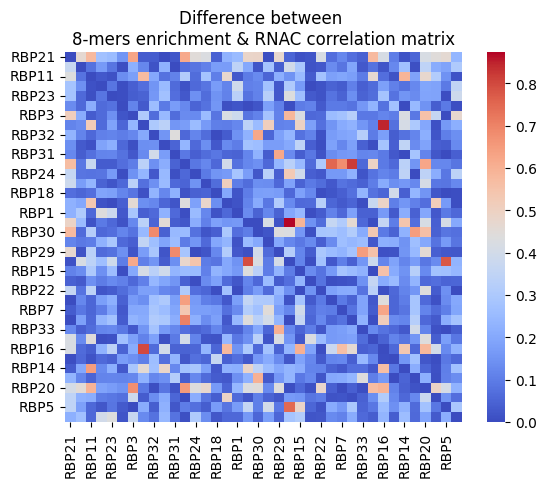

In [42]:
# see the difference between the two correlation matrix, the larger the difference, the more the difference between the two correlation matrix
corr_df_sub = corr_df.loc[rnac_corr.index, rnac_corr.columns]
# low difference means the 8-mers enrichment data is similar to the RNAC data. in that case the mission is feasible
# scale both the correlation matrix to 0-1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
corr_df_sub_scaled = scaler.fit_transform(corr_df_sub)
rnac_corr_scaled = scaler.fit_transform(rnac_corr)

# calculate the p value using t test between the two correlation matrix
from scipy.stats import ttest_ind

# check if the two matrices corrolated to each other
ttest_ind(corr_df_sub_scaled.flatten(), rnac_corr_scaled.flatten())
print('p value:', ttest_ind(corr_df_sub_scaled.flatten(), rnac_corr_scaled.flatten()).pvalue)
diff_df = pd.DataFrame(corr_df_sub_scaled - rnac_corr_scaled, index=rnac_corr.index, columns=rnac_corr.columns)
diff_df = diff_df.abs()
# sort the columns

sns.heatmap(diff_df, annot=False, cmap='coolwarm')

# set title for the heatmap
plt.title('Difference between \n8-mers enrichment & RNAC correlation matrix')

#Imputing Missing Cycles for Proteins with single cycle

To impute missing cycles in the training data, we will use data from other proteins with high corrolation of the RNA compelte resuls values, as this aligns with our final goal.  
For the test data, we will use proteins with a high correlation to the 8-mer enrichment data.

In [48]:
have_rnac = rnac_corr.columns.tolist()
not_have_rnac = [i for i in enrichment_df.columns if i not in have_rnac]
print(f'not have rnac: {len(not_have_rnac)},\n have rnac: {len(have_rnac)}')

not have rnac: 38,
 have rnac: 38


In [49]:
htr_data_dir = '/home/dsi/toozig/Deep-learning-RNA-binding/data/raw_data/htr-selex'
htr_data = os.listdir(htr_data_dir)
have_rnac_4_cycles = [i for i in have_rnac if len([j for j in htr_data if i == j.split('_')[0]]) == 4]
have_rnac_1_cycle = [i for i in have_rnac if len([j for j in htr_data if i  == j.split('_')[0]]) == 1]
not_habe_rnac_1_cycle = [i for i in not_have_rnac if len([j for j in htr_data if i  == j.split('_')[0]]) == 1]
len(have_rnac_4_cycles),len(not_habe_rnac_1_cycle),len(have_rnac_1_cycle)
corr_df_sub = corr_df.loc[not_habe_rnac_1_cycle, have_rnac_4_cycles]

(33, 4, 3)

<Figure size 700x500 with 0 Axes>

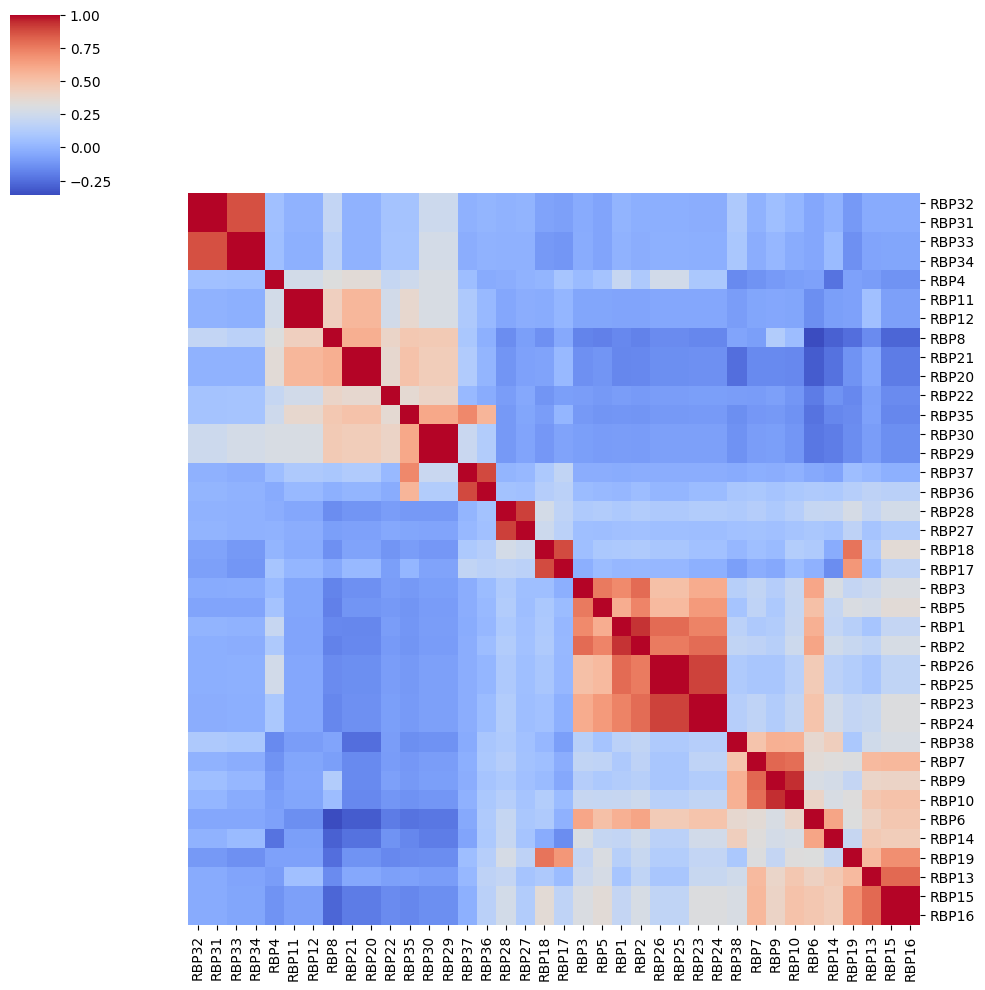

In [45]:
# keep the columns that are in have_rnac and the index that are in not_have_rnac


plt.figure(figsize=(7, 5))
# sns.clustermap(corr_df_sub, annot=False, cmap='coolwarm')
# change figure size
# plt.figure(figsize=(10, 10))
cg = sns.clustermap(corr_df_sub, annot=False, cmap='coolwarm')
# add title to the heatmap
cg.ax_row_dendrogram.set_visible(False) #suppress row dendrogram

# cg.title('8-mers enrichment similarity heatmap')
cg.ax_col_dendrogram.set_visible(False) #suppress column dendrogram

plt.show()

<Figure size 700x500 with 0 Axes>

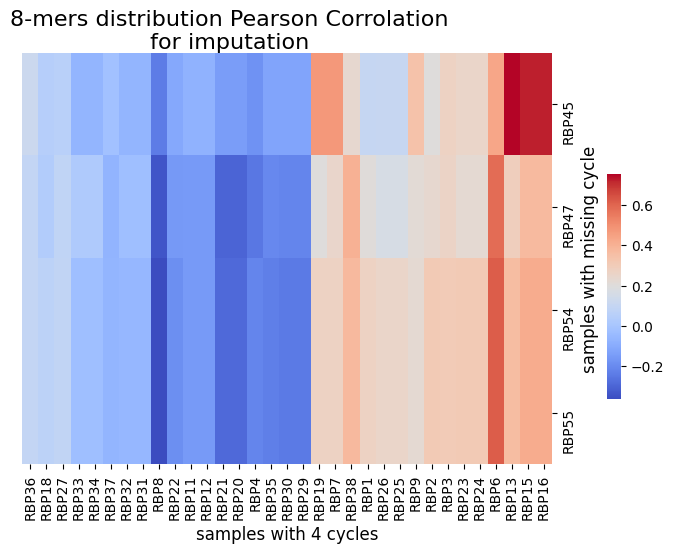

In [78]:
mers_sub = corr_df.loc[not_habe_rnac_1_cycle, have_rnac_4_cycles]

plt.figure(figsize=(7, 5))
cg = sns.clustermap(mers_sub, annot=False, cmap='coolwarm')


# add title to the heatmap
cg.ax_row_dendrogram.set_visible(False) #suppress row dendrogram

# cg.title('8-mers enrichment similarity heatmap')
cg.ax_col_dendrogram.set_visible(False) #suppress column dendrogram

# move the legend to the right

cg.fig.suptitle('8-mers distribution Pearson Corrolation\n for imputation ', fontsize=16)
# adjust suptitle position
cg.fig.subplots_adjust(top=1.1)

# adjust the figure size
cg.fig.set_size_inches(7, 5)

# set x and y label
cg.ax_heatmap.set_xlabel('samples with 4 cycles', fontdict={'fontsize': 12})
cg.ax_heatmap.set_ylabel('samples with missing cycle', fontdict={'fontsize': 12})

cg.cax.set_position([1.04,0.2,0.02,0.45])

plt.show()

<Figure size 700x500 with 0 Axes>

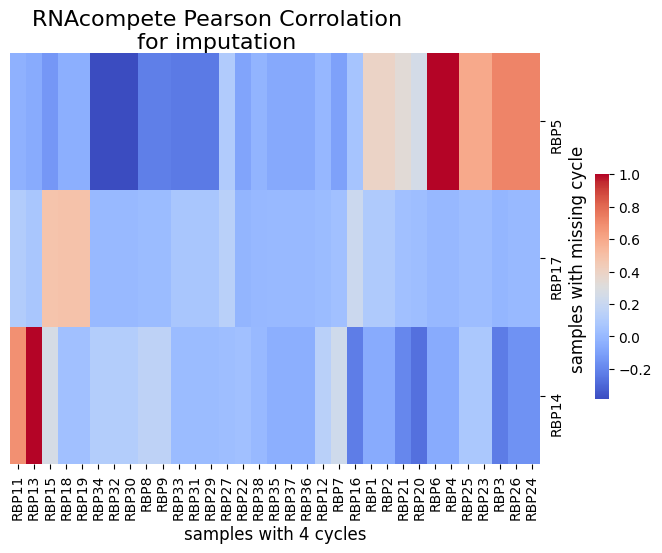

In [76]:
ranac_sub = rnac_corr.loc[have_rnac_1_cycle, have_rnac_4_cycles]

plt.figure(figsize=(7, 5))
cg = sns.clustermap(ranac_sub, annot=False, cmap='coolwarm')


# add title to the heatmap
cg.ax_row_dendrogram.set_visible(False) #suppress row dendrogram

# cg.title('8-mers enrichment similarity heatmap')
cg.ax_col_dendrogram.set_visible(False) #suppress column dendrogram

# move the legend to the right

cg.fig.suptitle('RNAcompete Pearson Corrolation\n for imputation ', fontsize=16)
# adjust suptitle position
cg.fig.subplots_adjust(top=1.1)

# adjust the figure size
cg.fig.set_size_inches(7, 5)

# set x and y label
cg.ax_heatmap.set_xlabel('samples with 4 cycles', fontdict={'fontsize': 12})
cg.ax_heatmap.set_ylabel('samples with missing cycle', fontdict={'fontsize': 12})

cg.cax.set_position([1.04,0.2,0.02,0.45])

plt.show()

In [29]:
# for each index in not_have_rnac, find the most similar index in have_rnac_4_cycles
most_similar = {}
for i in not_habe_rnac_1_cycle:
    most_similar[i] = corr_df_sub.loc[i].idxmax()

for i in have_rnac_1_cycle:
    most_similar[i] = ranac_sub.loc[i].idxmax()
most_similar

{'RBP54': 'RBP15',
 'RBP47': 'RBP38',
 'RBP55': 'RBP15',
 'RBP45': 'RBP13',
 'RBP14': 'RBP13',
 'RBP17': 'RBP18',
 'RBP5': 'RBP4'}